In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext import datasets
from torchtext.data import Field, LabelField

import random

from typing import List, Dict, Tuple, Union, Generator

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
SEED = 42  

TEXT = Field(tokenize='spacy',batch_first=True, include_lengths=True)
LABEL = LabelField(dtype = torch.float, batch_first=True)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, val_data = train_data.split(random_state = random.seed(SEED))

First, let's check if this is a balanced dataset.

In [3]:
from collections import Counter 

print(f"train_data label count: {Counter(list(train_data.label))}")
print(f"val_data label count: {Counter(list(val_data.label))}")

train_data label count: Counter({'pos': 8763, 'neg': 8737})
val_data label count: Counter({'neg': 3763, 'pos': 3737})


In [4]:
print(f"ratio of positive reviews in train_data: {8763 / (8763 + 8737)}")
print(f"ratio of positive reviews in val_data: {3737 / (3763 + 3737)}")

ratio of positive reviews in train_data: 0.5007428571428572
ratio of positive reviews in val_data: 0.4982666666666667


Let's take a look at the train_data

In [5]:
train_data[0].text[:10], train_data[0].label


(['Cedric',
  'Kahn',
  "'s",
  'films',
  'have',
  'been',
  'character',
  '-',
  'based',
  ','],
 'neg')

Each review contains the list of words, and the sentiment. We will vectorize the text with top 10000 occuring words.

In [6]:
def top_words(reviews: torchtext.data.dataset.Dataset, topk: int=10000) -> Dict:
  """
  given reviews return the topk words
  """
  word_count = dict()
  for review in reviews:
    for word in review.text:
      word_count[word] = word_count.get(word, 0) + 1
  topk_words = [k for k, v in sorted(word_count.items(), key=lambda x: x[1], reverse=True)][:topk]
  return {w: i for i, w in enumerate(topk_words)}

TOP10k = top_words(train_data)

In [7]:
def vectorize_sequence(text: List, dimension:int=10000) -> torch.Tensor:
  vector = torch.zeros(dimension)
  for w in text:
    idx = TOP10k.get(w, None)
    if idx is not None:
      vector[idx] = 1
  return vector

In [8]:
class ReviewDataset(Dataset):
  def __init__(self, data: torchtext.data.dataset.Dataset):
    self.data = data
  
  def __getitem__(self, idx:int) -> (torch.Tensor, torch.Tensor):
    text, label = self.data[idx].text, self.data[idx].label
    return vectorize_sequence(text), torch.tensor(float(label == 'pos'))
  
  def __len__(self):
    return len(self.data)

In [9]:
train_ds = ReviewDataset(train_data)
val_ds = ReviewDataset(val_data)
test_ds = ReviewDataset(test_data)

Here's what the train_ds looks like:

In [10]:
train_ds[1]

(tensor([1., 1., 1.,  ..., 0., 0., 0.]), tensor(1.))

In [11]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2)
test_dl = DataLoader(test_ds, batch_size=batch_size*2)

Given a balanced set, the accuracy should be around 50% with random guessing

In [12]:
TPandFN = 0
for _, targets in train_dl:
  size = len(targets)
  outputs = torch.rand(size) >= 0.5
  TPandFN += torch.sum(outputs == targets)

print(TPandFN / len(train_data))

tensor(0.4942)


First Model

In [13]:
#@title
class BinaryClassifierBase(nn.Module):
  def training_step(self, batch: Tuple) -> torch.Tensor:
    vectors, targets = batch
    out = self(vectors)    # calls the forward method
    loss = F.binary_cross_entropy(out, targets.reshape(-1,1))
    return loss
  
  def validation_step(self, batch:Tuple) -> Dict:
    vectors, targets = batch
    out = self(vectors)    # calls the forward method
    loss = F.binary_cross_entropy(out, targets.reshape(-1,1)).detach()    # will stack it to get mean later, must be a tensor
    acc = accuracy(out, targets)
    return {'val_loss': loss, 'val_acc': acc}
  

  @staticmethod
  def validation_epoch_end(outputs: List) -> Dict:
    """
    outputs: a list of {'val_loss': loss, 'val_acc': acc} for every batch in val_dl
    return: averaged val_loss and val_acc across batches in val_dl
    """
    batch_losses = [o['val_loss'] for o in outputs]
    batch_accs = [o['val_acc'] for o in outputs]
    epoch_loss = torch.stack(batch_losses).mean().item()
    epoch_acc = torch.stack(batch_accs).mean().item()
    return {'val_loss': epoch_loss, 'val_acc': epoch_acc}
    

  @staticmethod
  def epoch_end(epoch: int, result: Dict):
    train_loss, val_loss, val_acc = \
      result['train_loss'], result['val_loss'], result['val_acc']
    print(f"Epoch {epoch}, train_loss: {train_loss}, val_loss: {val_loss}, val_acc: {val_acc}") 

In [14]:
class SentimentClassifier(BinaryClassifierBase):
  def __init__(self, name):
    super().__init__()
    self.name = name
    self.network = nn.Sequential(
        nn.Linear(10000, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    ) 
  
  def forward(self, x: torch.Tensor) -> nn.modules.container.Sequential:
    return self.network(x)

In [15]:
#@title
def default_device() -> torch.device:
  if torch.cuda.is_available():
    return torch.device('cuda')
  return torch.device('cpu')

def to_device(data: Union[List, Tuple, torch.Tensor], device: torch.device) -> Union[List, torch.Tensor]:
  if isinstance(data, (list, tuple)):
    return [to_device(d,device) for d in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl: DataLoader, device: torch.device):
    self.dl = dl
    self.device = device
  
  def __len__(self) -> int:
    return len(self.dl)
  
  def __iter__(self) -> Generator[torch.Tensor, None, None]:
    for batch in self.dl:
      yield to_device(batch, self.device)

In [16]:
#@title
device = default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [17]:
#@title
def accuracy(outputs, targets):
  # reshape targets from (batch_size, ), to (batch_size, 1)
  targets = targets.reshape(-1, 1)
  return torch.tensor(torch.sum((outputs >= 0.5) == targets).item() / targets.size(0))


def evaluate(model, val_dl):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(outputs)


def fit(model, train_dl, val_dl, epochs=10, lr=0.01, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  optimizer = opt_func(model.parameters(), lr=lr)
  history = []

  for epoch in range(epochs):

    model.train()
    train_losses = []

    for batch in train_dl:
      
      loss = model.training_step(batch)
      train_losses.append(loss.detach())
      loss.backward()

      optimizer.step()
      optimizer.zero_grad()
    
    result = evaluate(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    history.append(result)
    model.epoch_end(epoch, result)
  
  return history

Next, we are going to set up some experiments:

Control Group:  
```
  nn.Linear(10000, 16),
  nn.ReLU(),
  nn.Linear(16, 16),
  nn.ReLU(),
  nn.Linear(16, 1),
  nn.Sigmoid()
```

Treatment Groups:  
  - three hidden layers
  - one hidden layer
  - 32 hidden units
  - 64 hidden units
  - tanh avtivation

In [18]:
m1 = to_device(SentimentClassifier('original_model'), device)
hp1 = {'epochs': 10, 'lr': 0.01}


m2 = SentimentClassifier('three_hidden_layers')
m2.network = nn.Sequential(
        nn.Linear(10000, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    )
m2 = to_device(m2, device)
hp2 = {'epochs': 10, 'lr': 0.01}


m3 = SentimentClassifier('one_hidden_layer')
m3.network = nn.Sequential(
        nn.Linear(10000, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    )
m3 = to_device(m3, device)
hp3 = {'epochs': 10, 'lr': 0.01}


m4 = SentimentClassifier('32_hidden_units')
m4.network = nn.Sequential(
        nn.Linear(10000, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )
m4 = to_device(m4, device)
hp4 = {'epochs': 10, 'lr': 0.01}


m5 = SentimentClassifier('64_hidden_units')
m5.network = nn.Sequential(
        nn.Linear(10000, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()
    )
m5 = to_device(m5, device)
hp5 = {'epochs': 10, 'lr': 0.01}


m6 = SentimentClassifier('tanh_activation')
m6.network = nn.Sequential(
        nn.Linear(10000, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    )
m6 = to_device(m6, device)
hp6 = {'epochs': 10, 'lr': 0.01}



experiments = [(m1, hp1), 
               (m2, hp2),
               (m3, hp3),
               (m4, hp4),
               (m5, hp5),
               (m6, hp6),
               ]

history = dict()
duration = dict()
for m, hp in experiments:
  start_time = time.time()
  history[m.name] = [evaluate(m, val_dl)]
  history[m.name] += fit(m, train_dl, val_dl, **hp)
  duration[m.name] = time.time() - start_time
  print(f'------------------------------ End of Experiment')

Epoch 0, train_loss: 0.6909286975860596, val_loss: 0.6851983666419983, val_acc: 0.5578654408454895
Epoch 1, train_loss: 0.6645113825798035, val_loss: 0.6298986077308655, val_acc: 0.7956832647323608
Epoch 2, train_loss: 0.5412962436676025, val_loss: 0.4485180079936981, val_acc: 0.8262711763381958
Epoch 3, train_loss: 0.3810594975948334, val_loss: 0.3583565354347229, val_acc: 0.8484727740287781
Epoch 4, train_loss: 0.31063348054885864, val_loss: 0.3262156546115875, val_acc: 0.8591984510421753
Epoch 5, train_loss: 0.2711676061153412, val_loss: 0.3193463385105133, val_acc: 0.8632150292396545
Epoch 6, train_loss: 0.24194152653217316, val_loss: 0.3067779541015625, val_acc: 0.8727930784225464
Epoch 7, train_loss: 0.2192406803369522, val_loss: 0.323884516954422, val_acc: 0.8651571273803711
Epoch 8, train_loss: 0.20218081772327423, val_loss: 0.3330059349536896, val_acc: 0.8679378032684326
Epoch 9, train_loss: 0.18613894283771515, val_loss: 0.36332517862319946, val_acc: 0.8604784607887268
------

In [19]:
#@title
def plot_loss(history, ax):
  train_loss = [h.get('train_loss') for h in history]
  val_loss = [h.get('val_loss') for h in history]
  ax.plot(train_loss, '-x', label='train')
  ax.plot(val_loss, '-x', label='val')
  ax.legend()
  ax.set_xlabel('epoch')
  ax.set_ylabel('cross entropy loss')
  ax.set_title('Loss vs Epoch')

def plot_accuracy(history, ax):
  val_acc = [h.get('val_acc') for h in history]
  ax.plot(val_acc, '-x', label='val')
  ax.legend()
  ax.set_xlabel('epoch')
  ax.set_ylabel('Accuracy')
  ax.set_title('Accuracy vs Epoch')

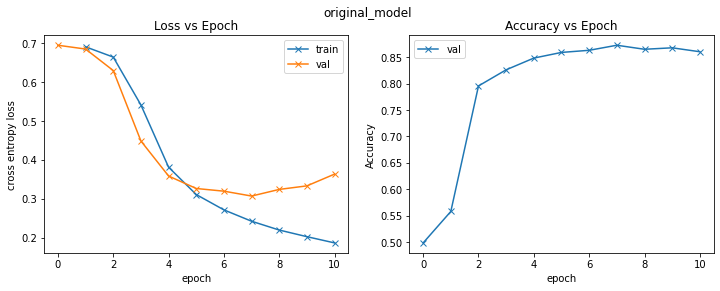

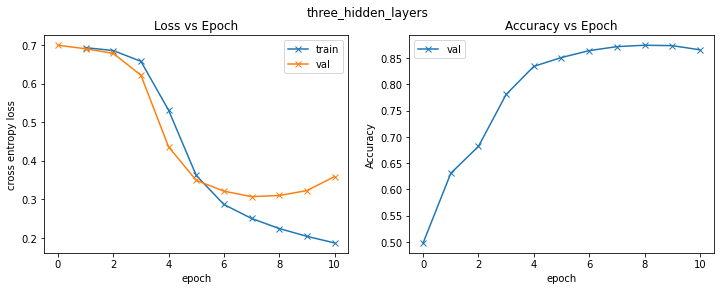

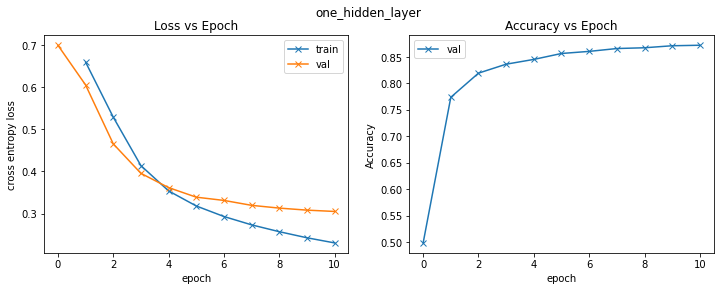

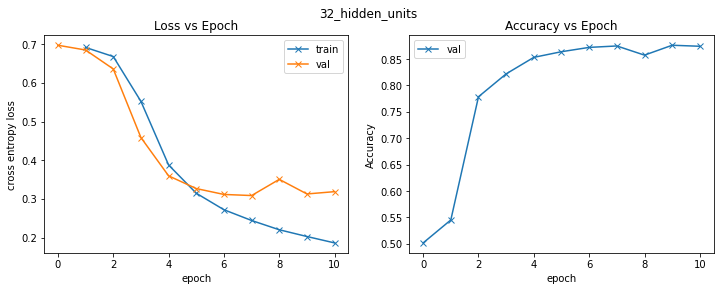

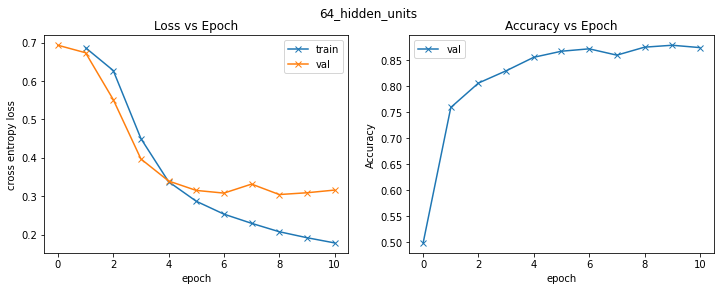

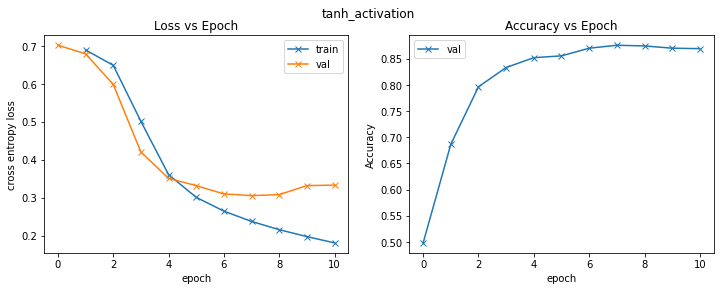

In [20]:
for name, data in history.items():
  fig, ax = plt.subplots(1, 2, figsize=(12,4))
  plot_loss(data, ax[0])
  plot_accuracy(data, ax[1])
  plt.suptitle(f'{name}')
  plt.show()

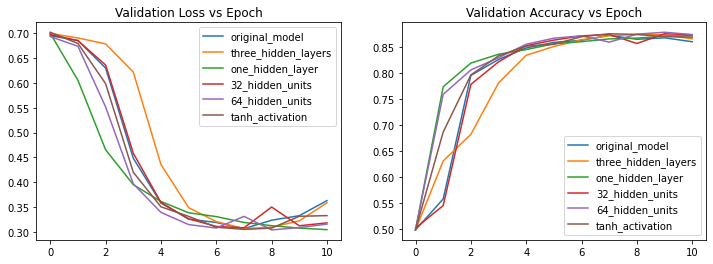

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for name, data in history.items():
  val_loss = [d['val_loss'] for d in data]
  ax[0].plot(val_loss, label=name)
  ax[0].set_title('Validation Loss vs Epoch')
  val_acc = [d['val_acc'] for d in data]
  ax[1].plot(val_acc, label=name)
  ax[1].set_title('Validation Accuracy vs Epoch')
ax[0].legend()
ax[1].legend()
plt.show()

The treatement group with three hidden layers does not seem to be a good choice. The others have similar performance in terms of validation accuracy, and how fast it converged.

In the next notebook, we will try the following regularization approaches:  
- dropout layers
- L2 regularization

Then we will tune the hyperparameters.
